## Grupo 001 - Lunes 7-10 PM
## Equipo 9
+ 1842161 Torres Guerrero Saul Ángel
+ 1844656 Maldonado Ramirez Alejandra
+ 1857712 Morales Tovar Carlos de Jesús
+ 1941500 Espinosa Orrante Jesús Alejandro
+ 1857810 Rivera Castillo Saúl Andrés

# **Aplicando la técnica de Series de Tiempo**

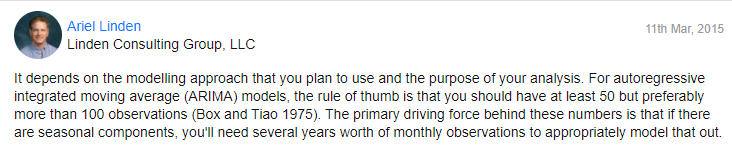

https://www.pluralsight.com/guides/advanced-time-series-modeling-(arima)-models-in-python

In [2]:
import pandas as pd
import numpy as np
import json
NNIP = pd.read_csv("indexProcessed.csv",parse_dates=['Date'],index_col= ['Date'])

In [3]:
NNYA=NNIP[NNIP.Index=="NYA"]
NNYA.head(5)

,Index,Open,High,Low,Close,Adj Close,Volume,CloseUSD
Date,,,,,,,,
1965-12-31,NYA,528.690002,528.690002,528.690002,528.690002,528.690002,0.0,528.690002
1966-01-03,NYA,527.210022,527.210022,527.210022,527.210022,527.210022,0.0,527.210022
1966-01-04,NYA,527.840027,527.840027,527.840027,527.840027,527.840027,0.0,527.840027
1966-01-05,NYA,531.119995,531.119995,531.119995,531.119995,531.119995,0.0,531.119995
1966-01-06,NYA,532.070007,532.070007,532.070007,532.070007,532.070007,0.0,532.070007


In [4]:
ENYA=NNYA.drop(columns=['Open','High','Low','Close','Adj Close'])
ENYA.head(6)

,Index,Volume,CloseUSD
Date,,,
1965-12-31,NYA,0.0,528.690002
1966-01-03,NYA,0.0,527.210022
1966-01-04,NYA,0.0,527.840027
1966-01-05,NYA,0.0,531.119995
1966-01-06,NYA,0.0,532.070007
1966-01-07,NYA,0.0,532.599976


In [5]:
RPP = ENYA['2020-01-01':'2021-05-01']
RPP.head()

,Index,Volume,CloseUSD
Date,,,
2020-01-02,NYA,3.458250e+09,14002.49023
2020-01-03,NYA,3.461290e+09,13917.04981
2020-01-06,NYA,3.674070e+09,13941.79981
2020-01-07,NYA,3.420380e+09,13898.45020
2020-01-08,NYA,3.720890e+09,13934.44043


### Revisando estacionariedad en media

In [6]:
RPP.reset_index()

,Date,Index,Volume,CloseUSD
0,2020-01-02,NYA,3.458250e+09,14002.49023
1,2020-01-03,NYA,3.461290e+09,13917.04981
2,2020-01-06,NYA,3.674070e+09,13941.79981
3,2020-01-07,NYA,3.420380e+09,13898.45020
4,2020-01-08,NYA,3.720890e+09,13934.44043
...,...,...,...,...
330,2021-04-26,NYA,3.738920e+09,16241.20996
331,2021-04-27,NYA,3.703240e+09,16273.30957
332,2021-04-28,NYA,3.772390e+09,16322.12988
333,2021-04-29,NYA,4.288940e+09,16376.00000


In [8]:
import matplotlib.pyplot as plt
x = np.arange(RPP.reset_index()['Date'].size)
fit = np.polyfit(x, RPP['CloseUSD'], deg=1)
print ("Slope : " + str(fit[0]))
print ("Intercept : " + str(fit[1]))

Slope : 12.099763050321425
Intercept : 11285.917567309754


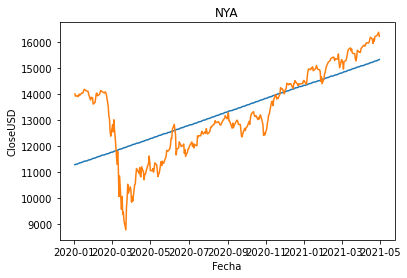

In [9]:
fit_function = np.poly1d(fit)
plt.plot(RPP.reset_index()['Date'], fit_function(x))
plt.plot(RPP.reset_index()['Date'], RPP['CloseUSD'])

plt.xlabel('Fecha')
plt.ylabel('CloseUSD')
plt.title('NYA')
plt.show()

Visualmente parece que se tiene tendencia lineal, la serie es no estacionaria en media

In [10]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X2 = np.arange(RPP.reset_index()['Date'].size).reshape(-1, 1)
y2 = RPP['CloseUSD']
X3 = sm.add_constant(X2)
est2 = sm.OLS(y2, X3)
est3 = est2.fit()
print(est3.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:               CloseUSD   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     343.9
Date:                Mon, 11 Oct 2021   Prob (F-statistic):           3.11e-53
Time:                        08:36:59   Log-Likelihood:                -2836.7
No. Observations:                 335   AIC:                             5677.
Df Residuals:                     333   BIC:                             5685.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.129e+04    125.916     89.631      0.0

#### Prueba de hipótesis

H0: la serie no tiene tendencia

H1: la serie tiene tendencia

Criterio: Rechazamos H0 si p-valor<alfa(0.05)

P-valor=0.000<0.05, con un 95% de confianza rechazamos H0

**La serie es no estacionaria en media**

### Revisando estacionariedad en varianza con la Prueba Dickey-Fuller Aumentada

In [11]:
RPP2=RPP.drop(columns=['Index','Volume'])
RPP2.head(6)

,CloseUSD
Date,
2020-01-02,14002.49023
2020-01-03,13917.04981
2020-01-06,13941.79981
2020-01-07,13898.45020
2020-01-08,13934.44043
2020-01-09,13997.65039


In [12]:
#Definiendo función para la Prueba Dickey-Fuller
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Resultados de la prueba Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-valor','#Lags Used','Numero de observaciones usadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

adf_test(RPP2['CloseUSD'])

Resultados de la prueba Dickey-Fuller:
Test Statistic                     -0.949656
p-valor                             0.771181
#Lags Used                          9.000000
Numero de observaciones usadas    325.000000
Critical Value (1%)                -3.450632
Critical Value (5%)                -2.870474
Critical Value (10%)               -2.571530
dtype: float64


#### Prueba de hipótesis
H0: la serie no es estacionaria

H1: la serie es estacionaria

Criterio: Rechazamos H0 si p-valor<alfa(0.05)

P-valor=0.771181>0.05, con un 95% de confianza no rechazamos H0

**La serie es no estacionaria en varianza**

## **Se tiene que corregir la serie para hacerse estacionaria**

### Correcciones

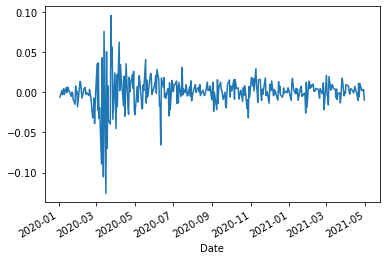

In [13]:
RPP2['CloseUSD_log'] = np.log(RPP2['CloseUSD'])
RPP2['CloseUSD_log_diff'] = RPP2['CloseUSD_log'] - RPP2['CloseUSD_log'].shift(1)
RPP2['CloseUSD_log_diff'].dropna().plot()

### Revisando estacionariedad en media

In [14]:
RPP2.reset_index()
RPP2_c = RPP2.reset_index().drop([0], axis=0)
RPP2_c

,Date,CloseUSD,CloseUSD_log,CloseUSD_log_diff
1,2020-01-03,13917.04981,9.540870,-0.006120
2,2020-01-06,13941.79981,9.542647,0.001777
3,2020-01-07,13898.45020,9.539533,-0.003114
4,2020-01-08,13934.44043,9.542119,0.002586
5,2020-01-09,13997.65039,9.546645,0.004526
...,...,...,...,...
330,2021-04-26,16241.20996,9.695307,0.002170
331,2021-04-27,16273.30957,9.697282,0.001974
332,2021-04-28,16322.12988,9.700277,0.002996
333,2021-04-29,16376.00000,9.703572,0.003295


In [15]:
import matplotlib.pyplot as plt
x = np.arange(RPP2_c['Date'].size)
fit = np.polyfit(x,RPP2_c['CloseUSD_log_diff'], deg=1)
print ("Slope : " + str(fit[0]))
print ("Intercept : " + str(fit[1]))

Slope : 1.4280063356096332e-05
Intercept : -0.0019376049249305346


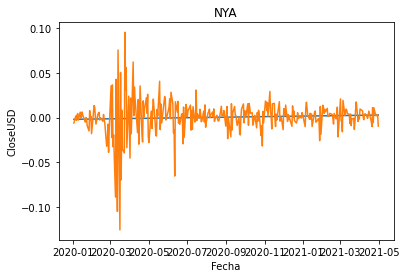

In [16]:
fit_function = np.poly1d(fit)
plt.plot(RPP2_c['Date'], fit_function(x))
plt.plot(RPP2_c['Date'], RPP2_c['CloseUSD_log_diff'])

plt.xlabel('Fecha')
plt.ylabel('CloseUSD')
plt.title('NYA')
plt.show()

Visualmente parece que no se tiene tendencia

In [18]:
X = np.arange(RPP2_c['Date'].size).reshape(-1, 1)
y = RPP2_c['CloseUSD_log_diff']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:      CloseUSD_log_diff   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.639
Date:                Mon, 11 Oct 2021   Prob (F-statistic):              0.201
Time:                        08:39:18   Log-Likelihood:                 839.54
No. Observations:                 334   AIC:                            -1675.
Df Residuals:                     332   BIC:                            -1667.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.002     -0.903      0.3

#### Prueba de hipótesis

H0: la serie no tiene tendencia

H1: la serie tiene tendencia

Criterio: Rechazamos H0 si p-valor<alfa(0.05)

P-valor=0.201>0.05, con un 95% de confianza no rechazamos H0

**La serie es estacionaria en media**


### Revisando estacionariedad en varianza con la Prueba Dickey-Fuller Aumentada



In [19]:
adf_test(RPP2['CloseUSD_log_diff'].dropna())

Resultados de la prueba Dickey-Fuller:
Test Statistic                     -4.974196
p-valor                             0.000025
#Lags Used                          8.000000
Numero de observaciones usadas    325.000000
Critical Value (1%)                -3.450632
Critical Value (5%)                -2.870474
Critical Value (10%)               -2.571530
dtype: float64


#### Prueba de hipótesis
H0: la serie no es estacionaria

H1: la serie es estacionaria

Criterio: Rechazamos H0 si p-valor<alfa(0.05)

P-valor=0.000025<0.05, con un 95% de confianza rechazamos H0

**La serie es estacionaria en media y varianza**

## **Modelo ARIMA**

In [20]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 29.0 MB/s 
     |████████████████████████████████| 9.8 MB 73.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [21]:
import pmdarima as pmd

def arimamodel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              trace=True)
    return autoarima_model

In [22]:
arima_model = arimamodel(RPP2['CloseUSD_log_diff'].dropna())
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1697.706, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1673.430, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1693.007, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1685.858, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1675.262, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1706.530, Time=0.58 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-1707.184, Time=0.21 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-1708.399, Time=0.12 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-1715.689, Time=0.10 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-1718.289, Time=0.43 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-1738.521, Time=1.13 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-1737.924, Time=0.84 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=-1732.126, Time=1.30 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-1736.085, Time=1.02 sec
 ARIMA(5,0,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  334
Model:               SARIMAX(4, 0, 1)   Log Likelihood                 877.493
Date:                Mon, 11 Oct 2021   AIC                          -1742.985
Time:                        08:40:47   BIC                          -1720.119
Sample:                             0   HQIC                         -1733.868
                                - 334                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9760      0.045    -21.719      0.000      -1.064      -0.888
ar.L2          0.1077      0.046      2.331      0.020       0.017       0.198
ar.L3          0.2467      0.043      5.708      0.000       0.162       0.331
ar.L4         -0.1034      0.038     -2.704      0.007      -0.178      -0.028
ma.L1          0.8671      0.033     26.134      0.000       0.802       0.932
sigma2         0.0003   1.14e-05     26.629      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       39.24   Jarque-Bera (JB):              1015.65
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               0.11   Skew:                            -0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**AIC** son las siglas de Akaike Information Criterion, que estima la cantidad relativa de información perdida por un modelo dado. En términos simples, se prefiere un valor de AIC más bajo. En el resultado anterior, se obtuvo el valor AIC más bajo de -1742.985 para el modelo ARIMA (4, 0, 1), y que se utiliza como estimador final.